In [1]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from utilsforecast.data import generate_series
from tinyshift.plot import corr_heatmap
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, generate_lag
from tinyshift.plot import stationarity_check, seasonal_decompose, residual_check
from tinyshift.series import fourier_seasonality
from scipy import signal
import holidays
import numpy as np
from statsforecast import StatsForecast
from utilsforecast.losses import rmse, mae, bias, cfe
from utilsforecast.evaluation import evaluate
from statsforecast.models import AutoARIMA, Naive, AutoETS, AutoTheta, AutoCES
import pandas as pd

/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/home/heylucasleao/forecasting/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = generate_series(3, with_trend=True, static_as_categorical=False, seed=42, freq="D")

In [3]:
df.isnull().sum()

unique_id    0
ds           0
y            0
dtype: int64

In [4]:
df = fill_gaps(df, freq="D", end="per_serie", id_col="unique_id", time_col="ds")

In [5]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [6]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [7]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [8]:
obsolote_ids

[]

In [9]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
0    (0.9894087777029937, 4.8574508252298796e-150)
1                         (0.998759437594496, 0.0)
2                        (0.9990776434701963, 0.0)
Name: y, dtype: object

In [10]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [11]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [12]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
0          foreCA                                                  0.616734
           theoretical_limit                                       0.560748
           stability_index                                         0.937922
           adi_cv                                (1.0, 0.28499520299004516)
           hurst_exponent         (0.3290861603798452, 0.13218639190520123)
1          foreCA                                                  0.702415
           theoretical_limit                                        0.55557
           stability_index                                           0.9567
           adi_cv                                (1.0, 0.31390442751597913)
           hurst_exponent       (0.28893923895853546, 0.032089718874560705)
2          foreCA                                                  0.691794
           theoretical_limit                                       0.558174
           stability_index                                 

In [13]:
df["lag_1"] = df.groupby("unique_id")["y"].transform(generate_lag)
df["detrend"] = df.groupby("unique_id")["y"].transform(signal.detrend)
df["detrend_lag_7"] = df.groupby("unique_id")["detrend"].transform(generate_lag, lag=7)

# ACF/PACF

In [14]:
df = df.set_index("ds")

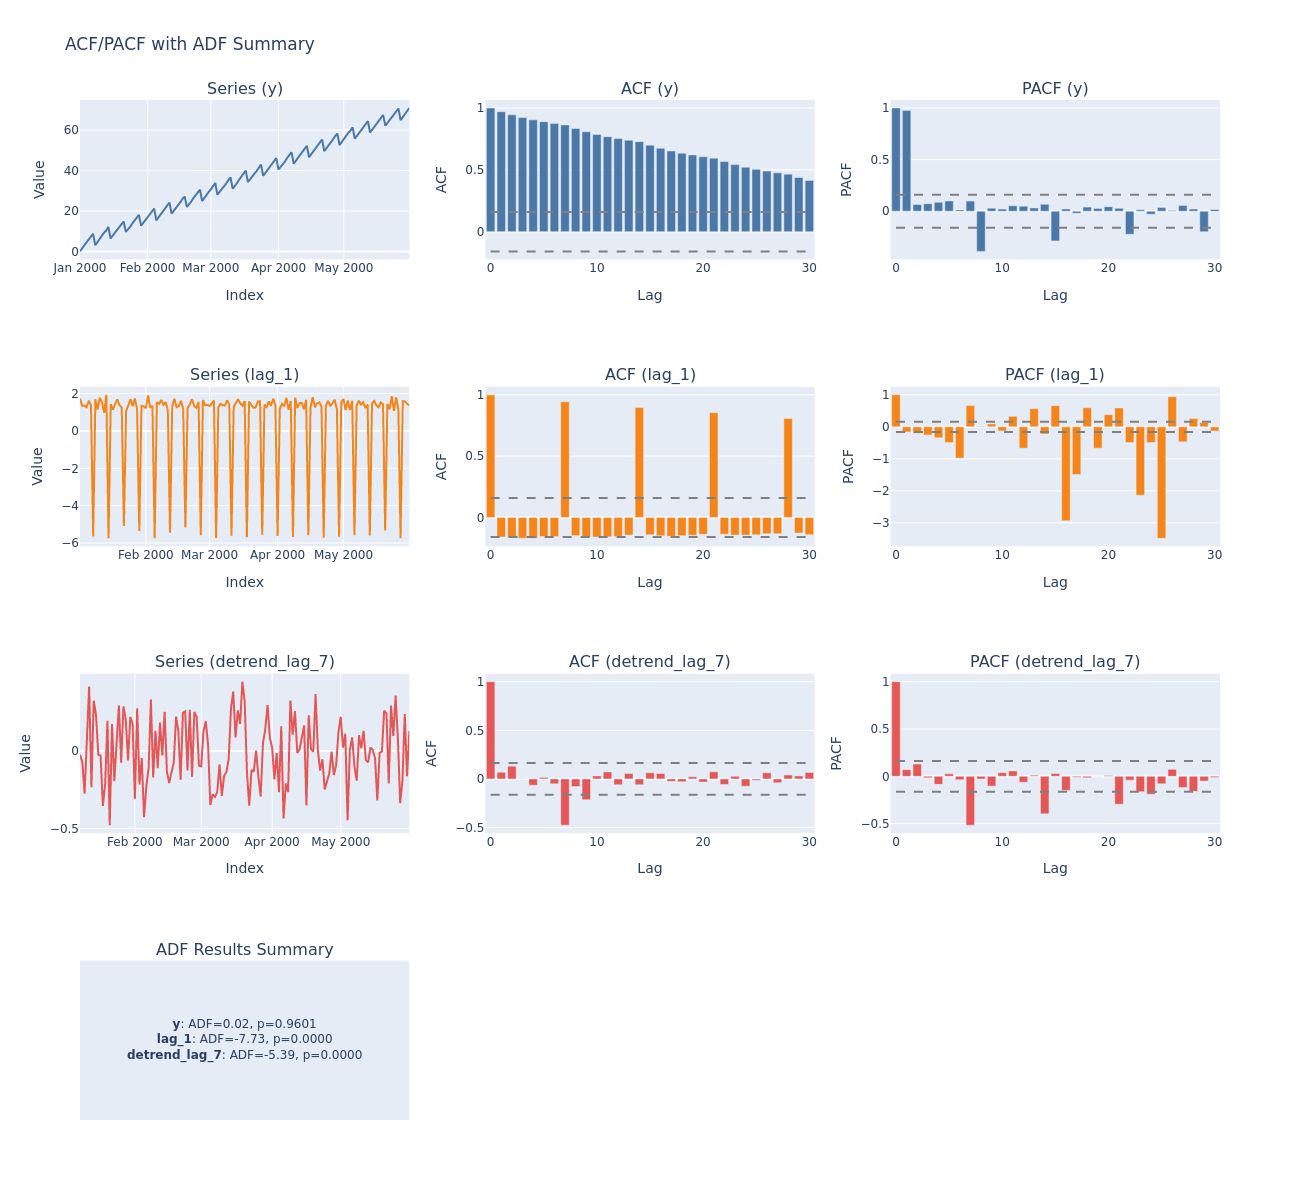

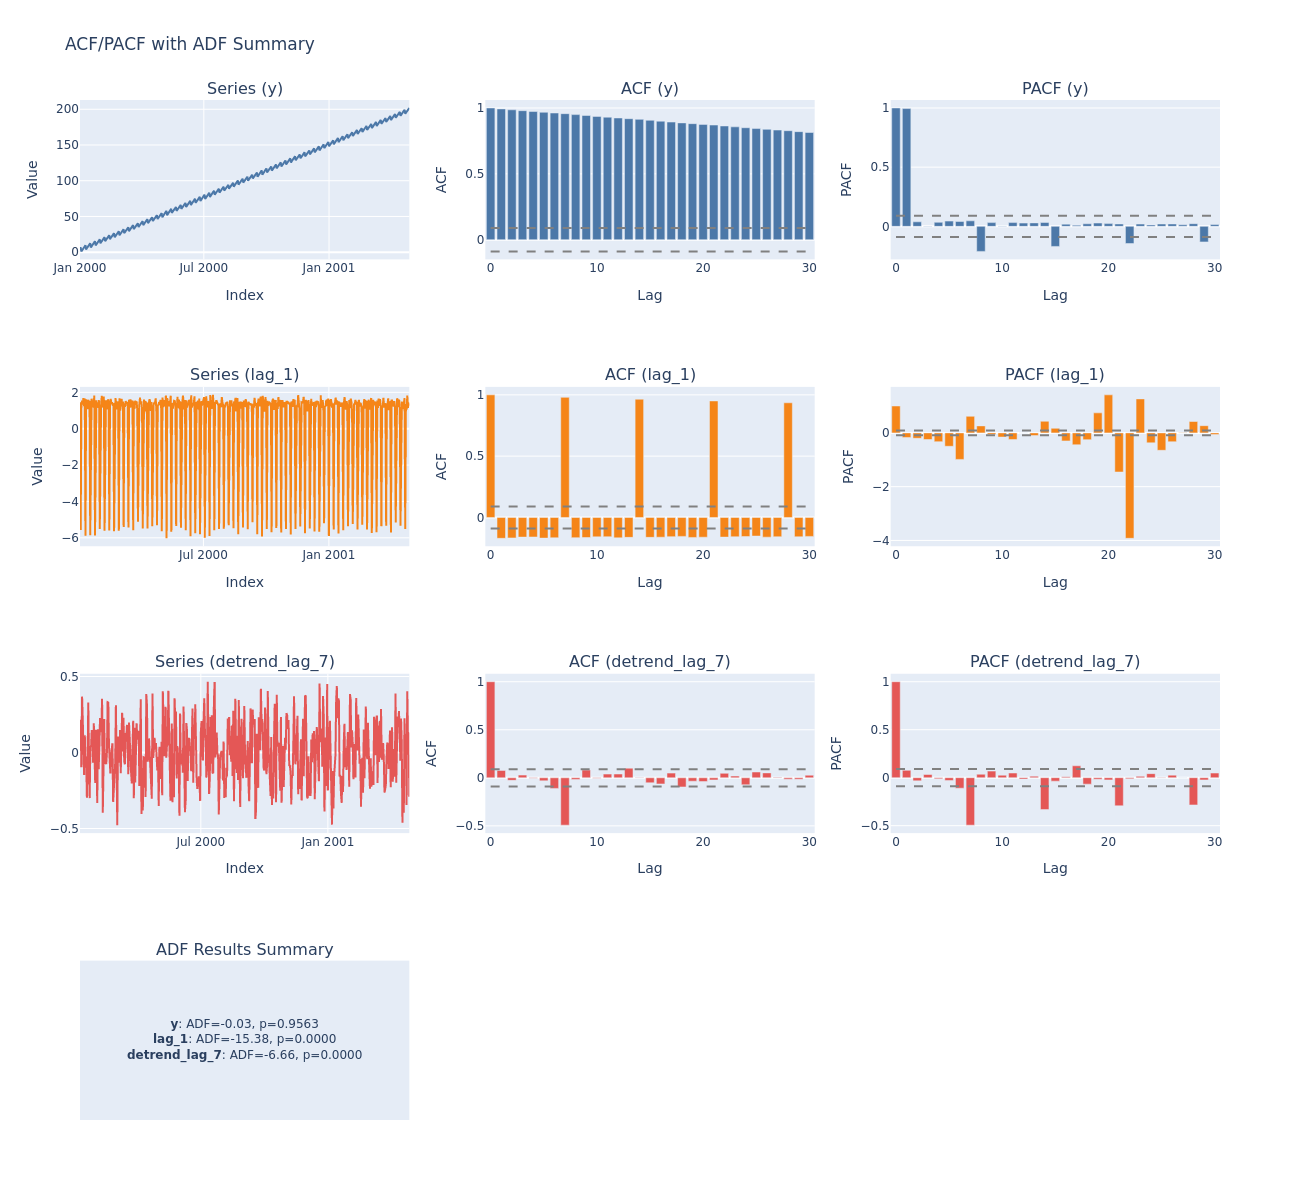

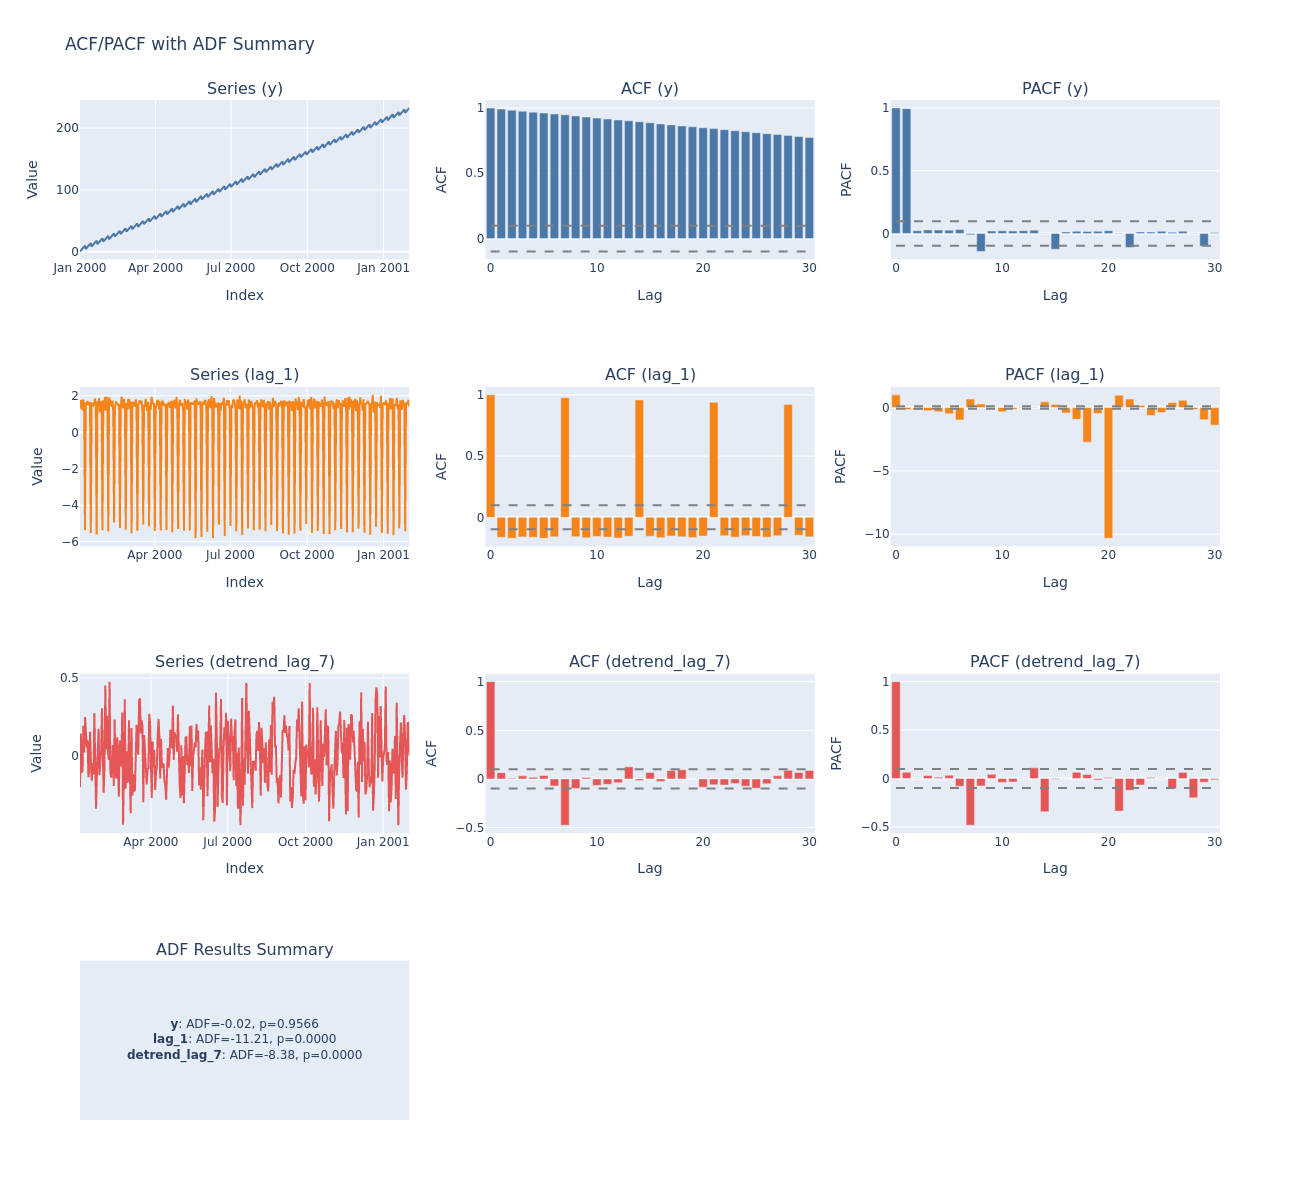

In [15]:
for id in df["unique_id"].unique():
    stationarity_check(df.loc[df["unique_id"] == id, ["y", "lag_1", "detrend_lag_7"]], fig_type="png")

# STL

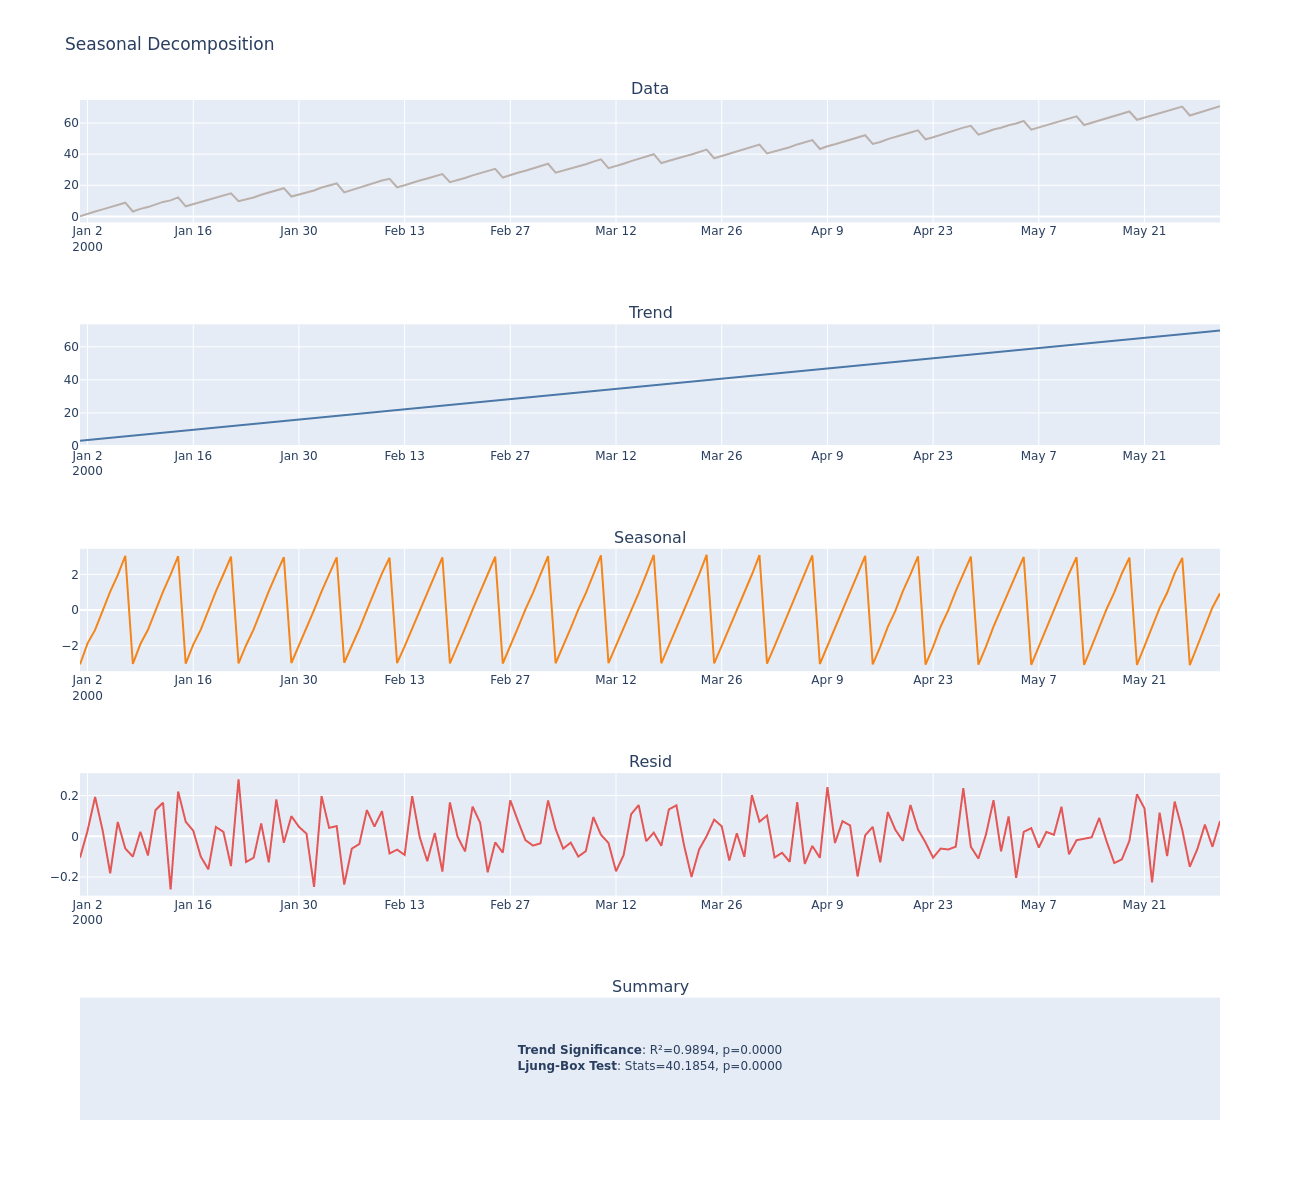

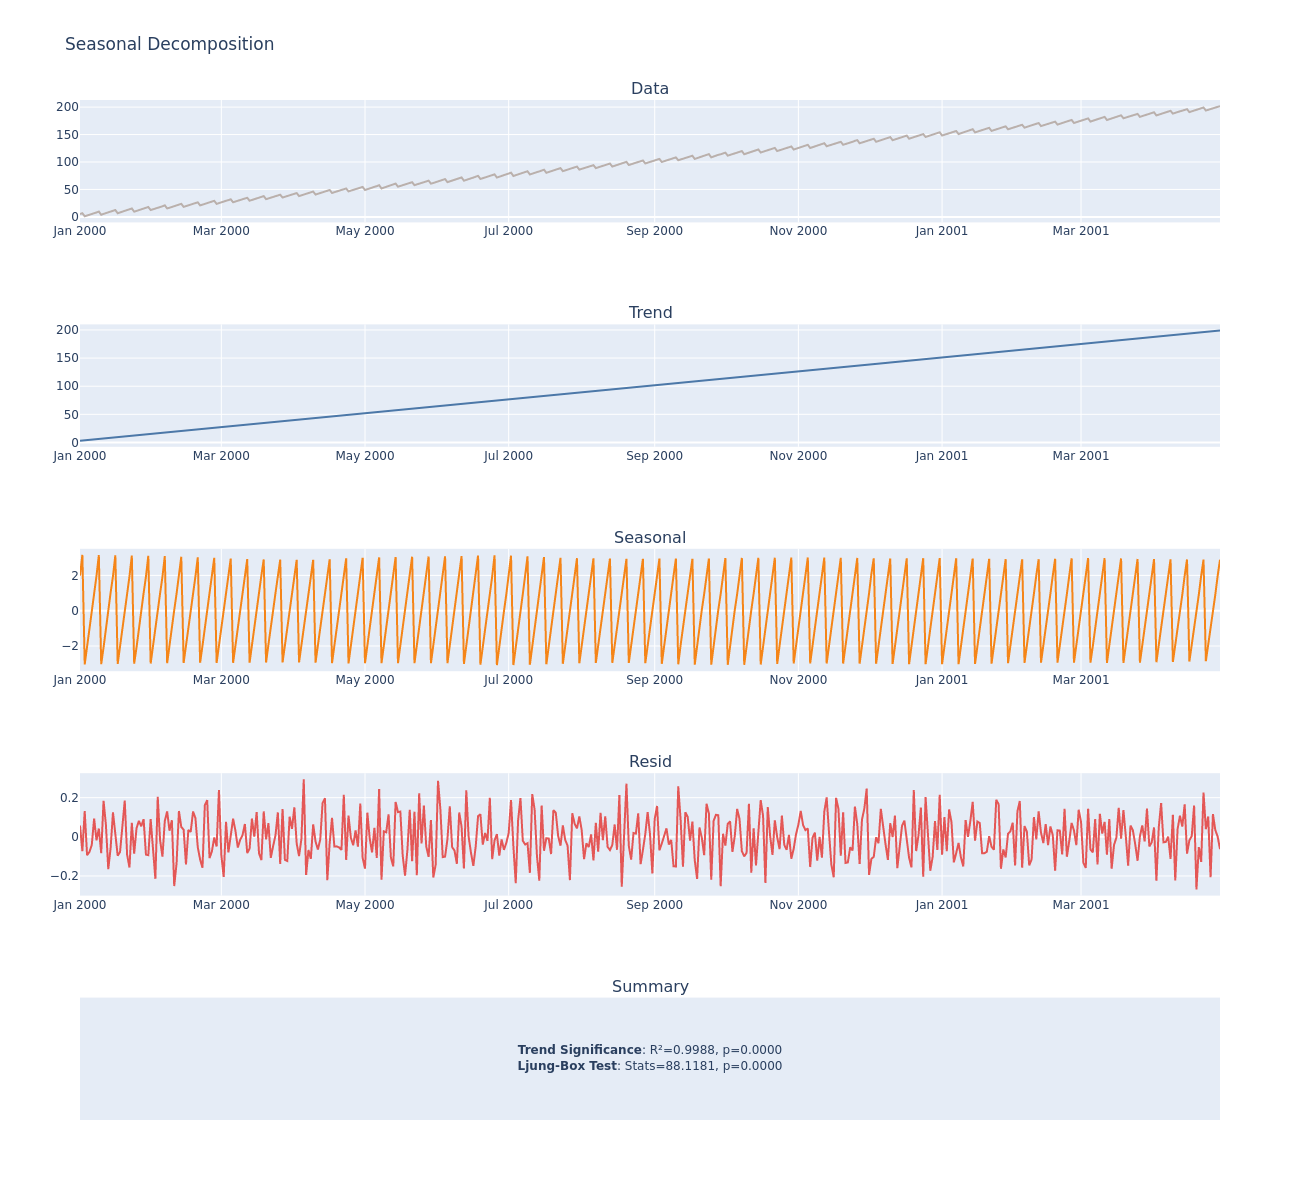

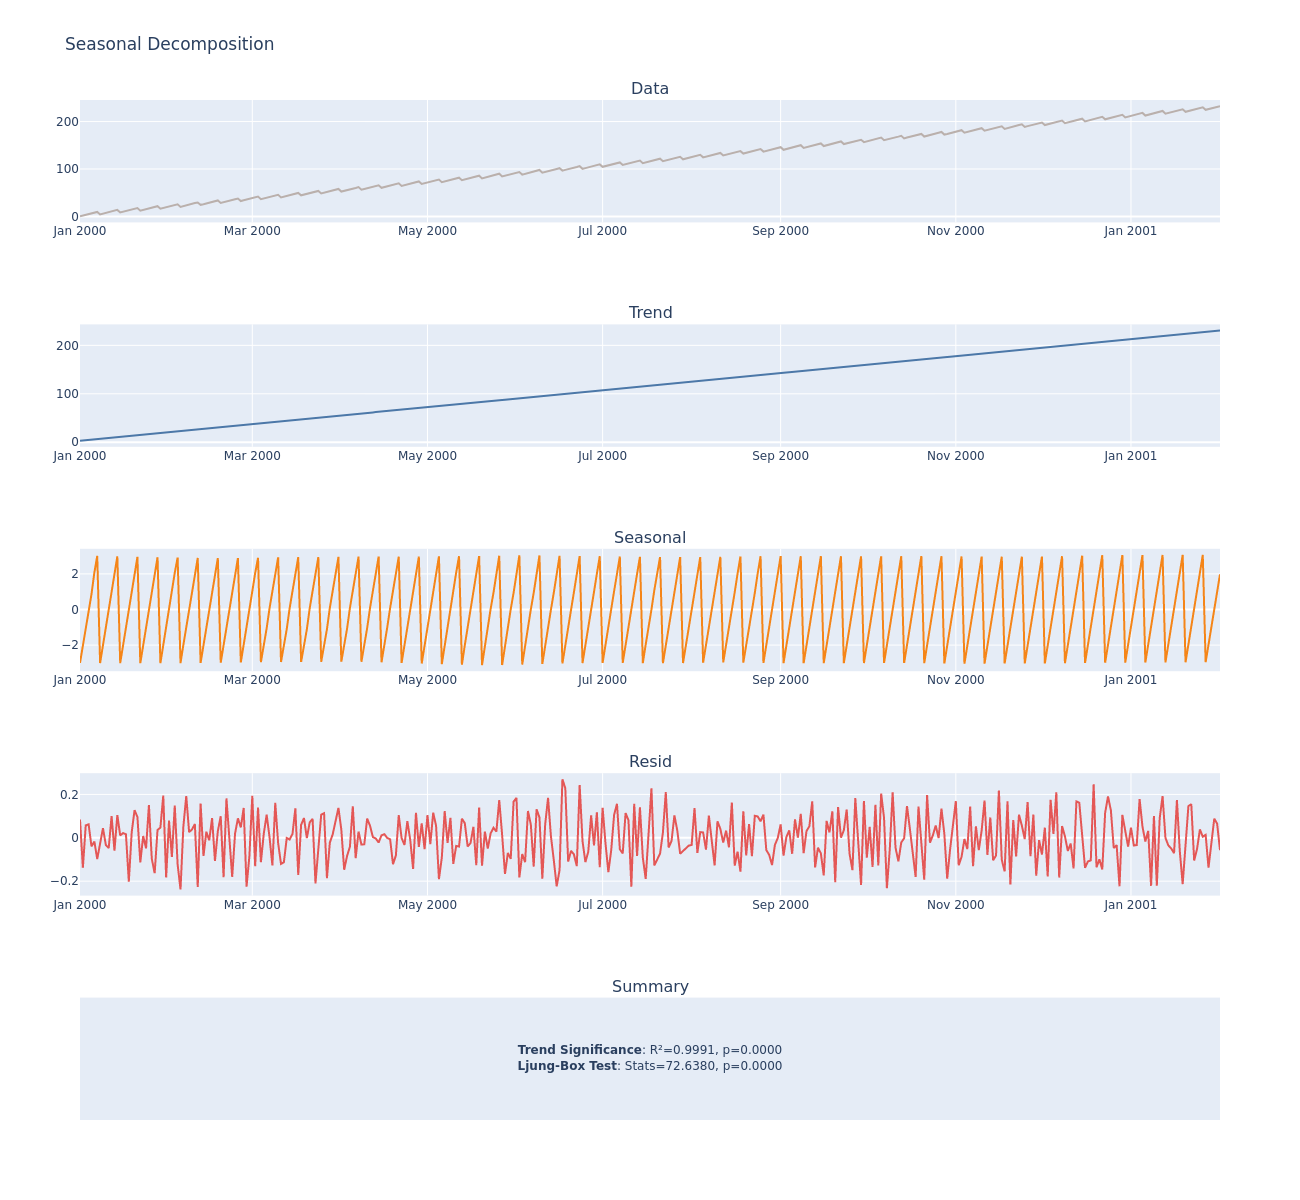

In [16]:
for id in df["unique_id"].unique():
    seasonal_decompose(
        df[df["unique_id"] == id]["y"],
        fig_type="png",
        periods=7,
    )

## Features
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [17]:
df = fourier_seasonality(df.reset_index(), "ds", seasonality=["weekly", "yearly"])
holidays_br = holidays.country_holidays("Brazil")
df["is_holiday"] = np.array([timestamp in holidays_br for timestamp in df["ds"]])
df["is_month_end"] = df["ds"].dt.is_month_end

In [18]:
df = df.dropna()

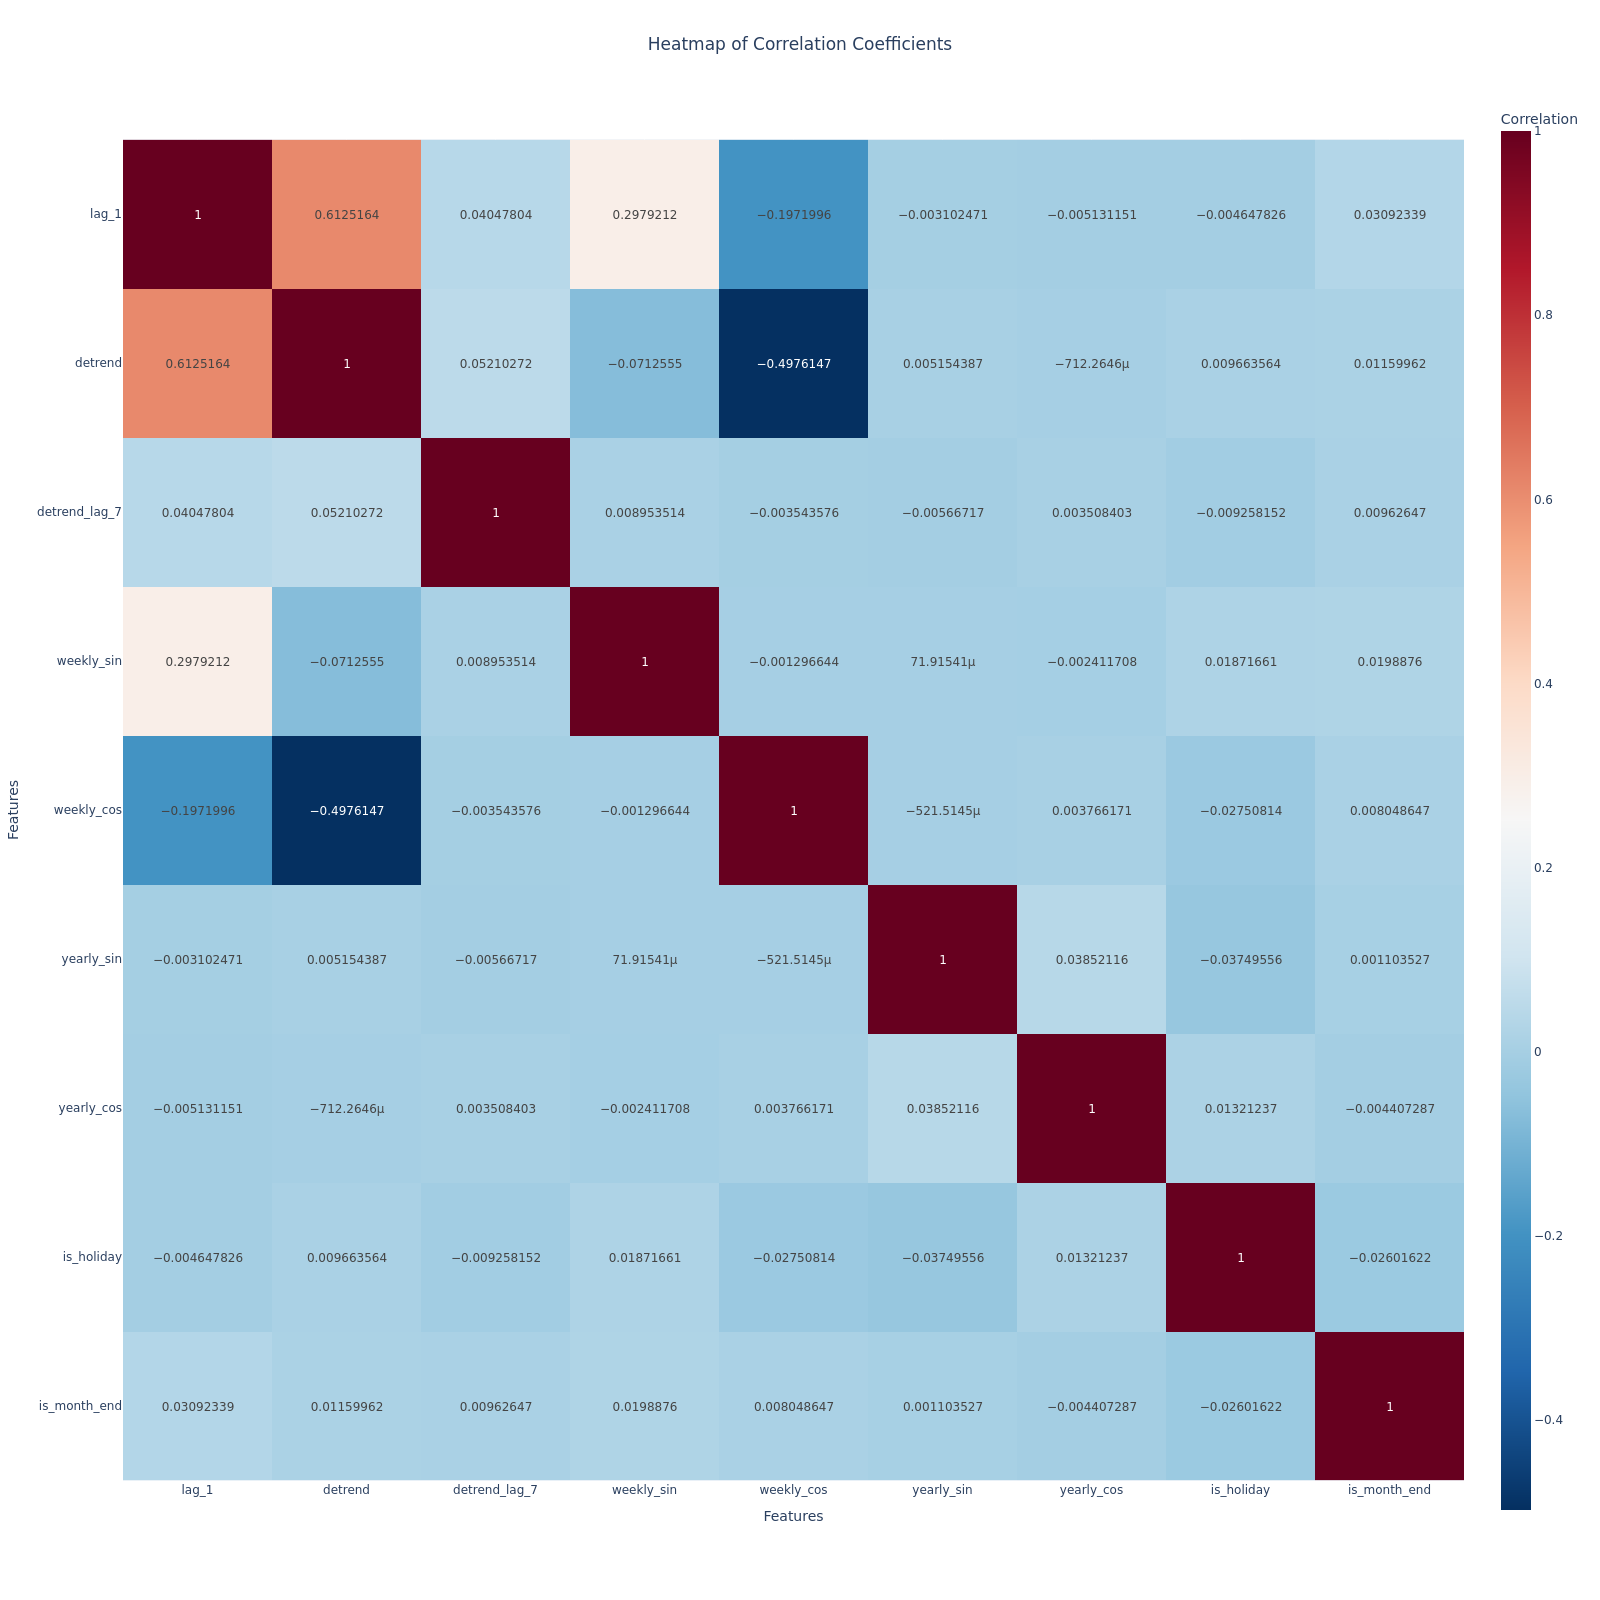

In [19]:
corr_heatmap(df[df.columns[3:]], fig_type="png")

# Modelagem Estatística

In [20]:
seasonal_length = 7
sf = StatsForecast(
    models=[
        AutoARIMA(season_length=seasonal_length),
        AutoETS(season_length=seasonal_length),
        AutoTheta(season_length=seasonal_length),
        AutoCES(season_length=seasonal_length),
    ],
    freq='D',
    fallback_model=Naive(),
    n_jobs=-1
)

In [21]:
horizon = 30
train = df.groupby('unique_id').head(-horizon).reset_index(drop=True)
test = df.groupby('unique_id').tail(horizon).reset_index(drop=True)

In [22]:
def wape(actual, forecast):
    return np.sum(np.abs(actual - forecast)) / np.sum(np.abs(actual))

In [23]:
fc = sf.forecast(df=train[["unique_id", "ds", "y"]], h=horizon) #fit_predict

In [24]:
metrics = [
    mae,
    rmse,
    bias,
    cfe
]
models = ["AutoARIMA", "AutoETS", "AutoTheta", "CES", "Ensemble"]
scum = ["AutoARIMA", "AutoETS", "AutoTheta", "CES"]

In [25]:
fc["Ensemble"] = fc[scum].median(axis=1)
fc.loc[fc["Ensemble"] < 1e-1, "Ensemble"] = 0

In [26]:
test = pd.merge(test, fc, on=["unique_id", "ds"], how="inner")
columns = ["unique_id", 
               "ds", 
               "y", 
               "AutoARIMA", 
               "AutoETS", 
               "AutoTheta", 
               "CES", 
               "Ensemble"]

In [27]:
test.groupby("unique_id")[test.columns].apply(lambda x: wape(x["y"], x["Ensemble"]))

unique_id
0    0.011617
1    0.001238
2    0.001326
dtype: float64

In [28]:
test.groupby("unique_id")[test.columns].apply(lambda x: wape(x["y"], x["AutoARIMA"]))

unique_id
0    0.001863
1    0.000636
2    0.000530
dtype: float64

In [29]:
evaluate(test[columns], 
         metrics=metrics, 
         models=models, 
         id_col="unique_id", 
         time_col="ds", 
         target_col="y")

,unique_id,metric,AutoARIMA,AutoETS,AutoTheta,CES,Ensemble
0,0,mae,0.118204,0.117160,2.817782,4.788348,0.736980
1,1,mae,0.122864,0.127738,4.450999,0.553172,0.239391
2,2,mae,0.117889,0.121499,4.293438,0.793892,0.294835
3,0,rmse,0.143891,0.136838,3.266078,5.625206,1.137482
4,1,rmse,0.141319,0.148544,5.085648,0.661118,0.315662
5,2,rmse,0.145919,0.152464,4.885838,0.914052,0.399064
6,0,bias,0.047541,0.021202,0.676148,4.788348,0.709622
7,1,bias,0.017623,0.023643,0.722320,0.546096,0.180858
8,2,bias,-0.004643,0.036408,0.834656,0.784464,0.255051
9,0,cfe,1.426229,0.636056,20.284450,143.650430,21.288656


# Análise de Resíduo

In [30]:
test["residual_arima"] = test["y"] - test["AutoARIMA"]
test["residual_ets"] = test["y"] - test["AutoETS"]
test["residual_autotheta"] = test["y"] - test["AutoTheta"]
test["residual_ces"] = test["y"] - test["CES"]
test["residual_ensemble"] = test["y"] - test["Ensemble"]

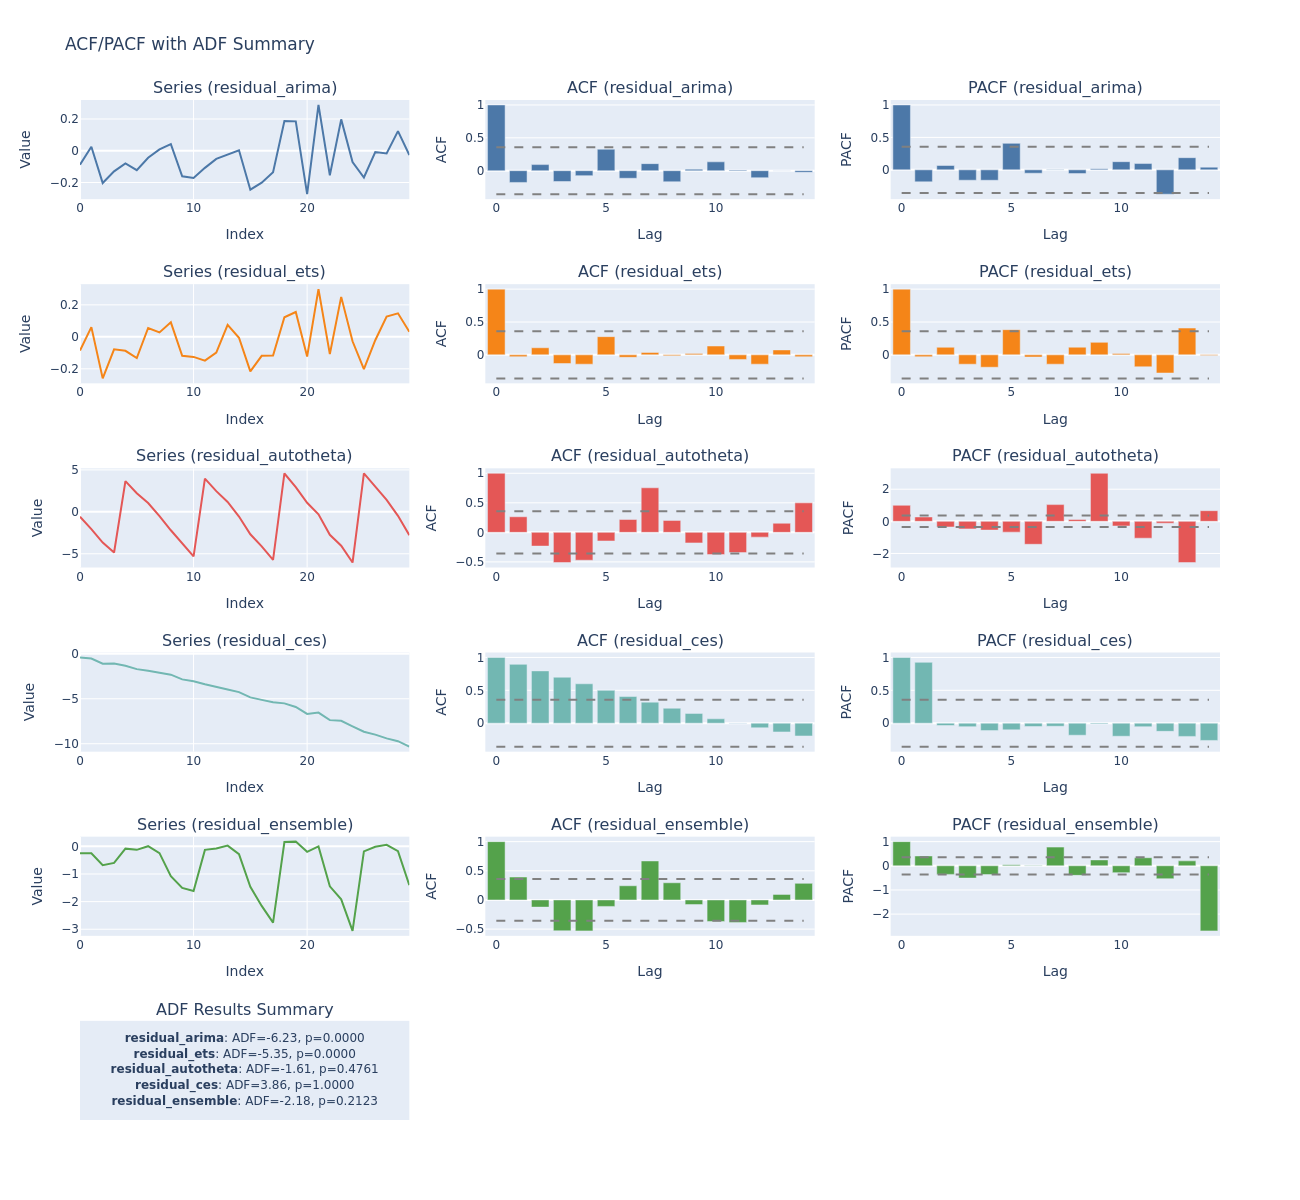

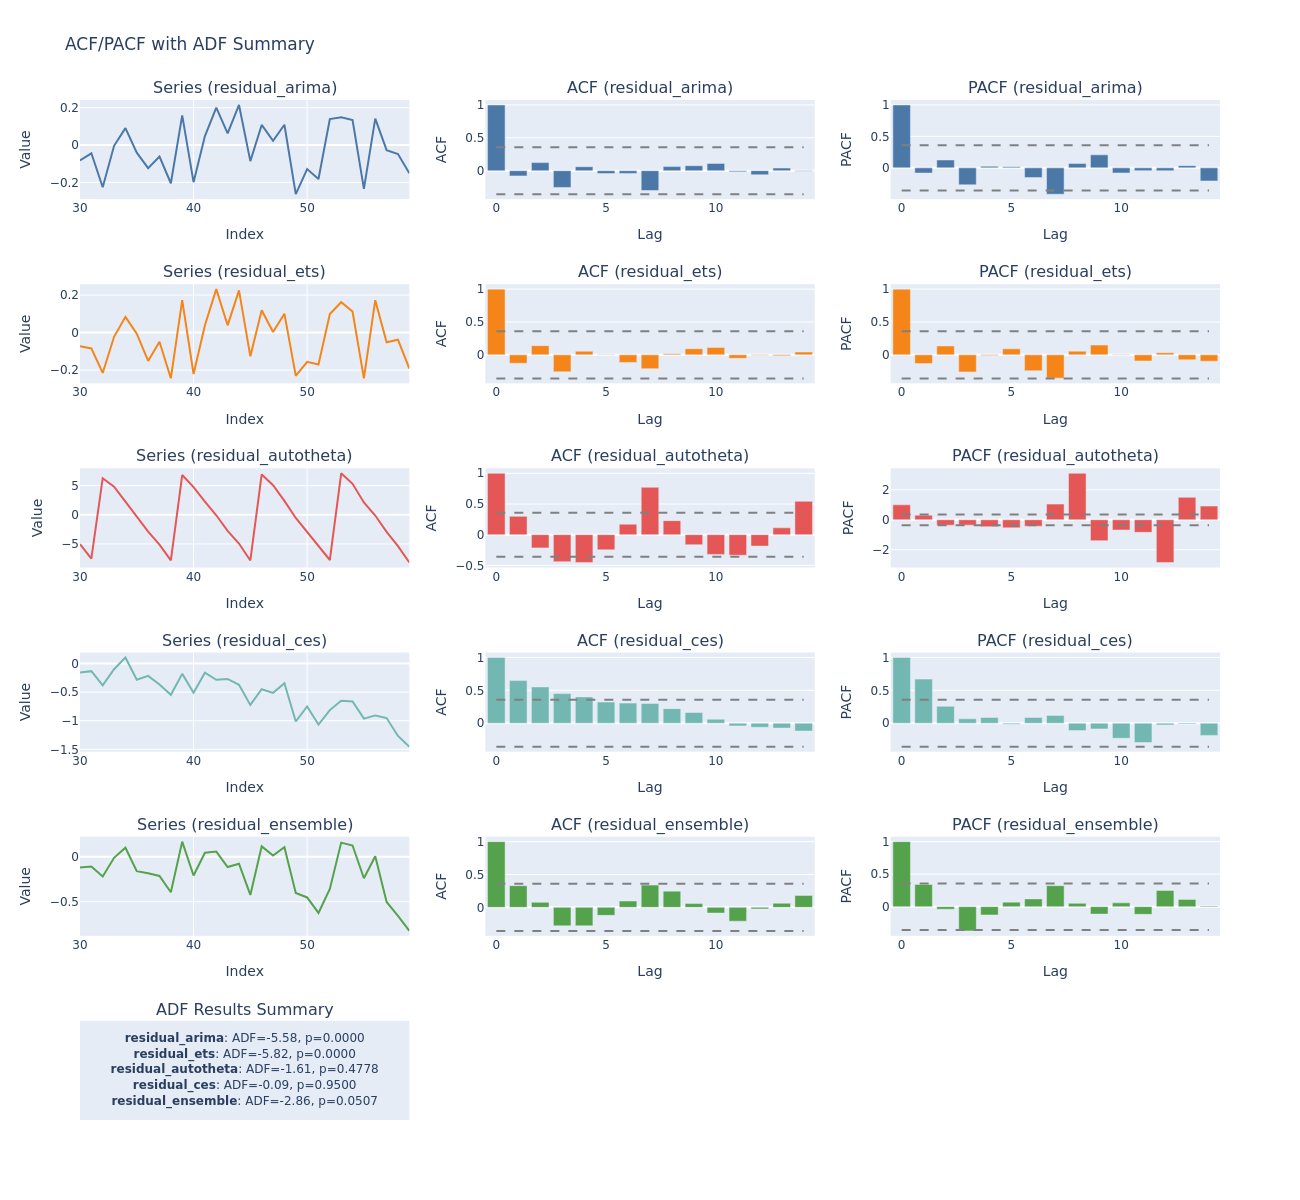

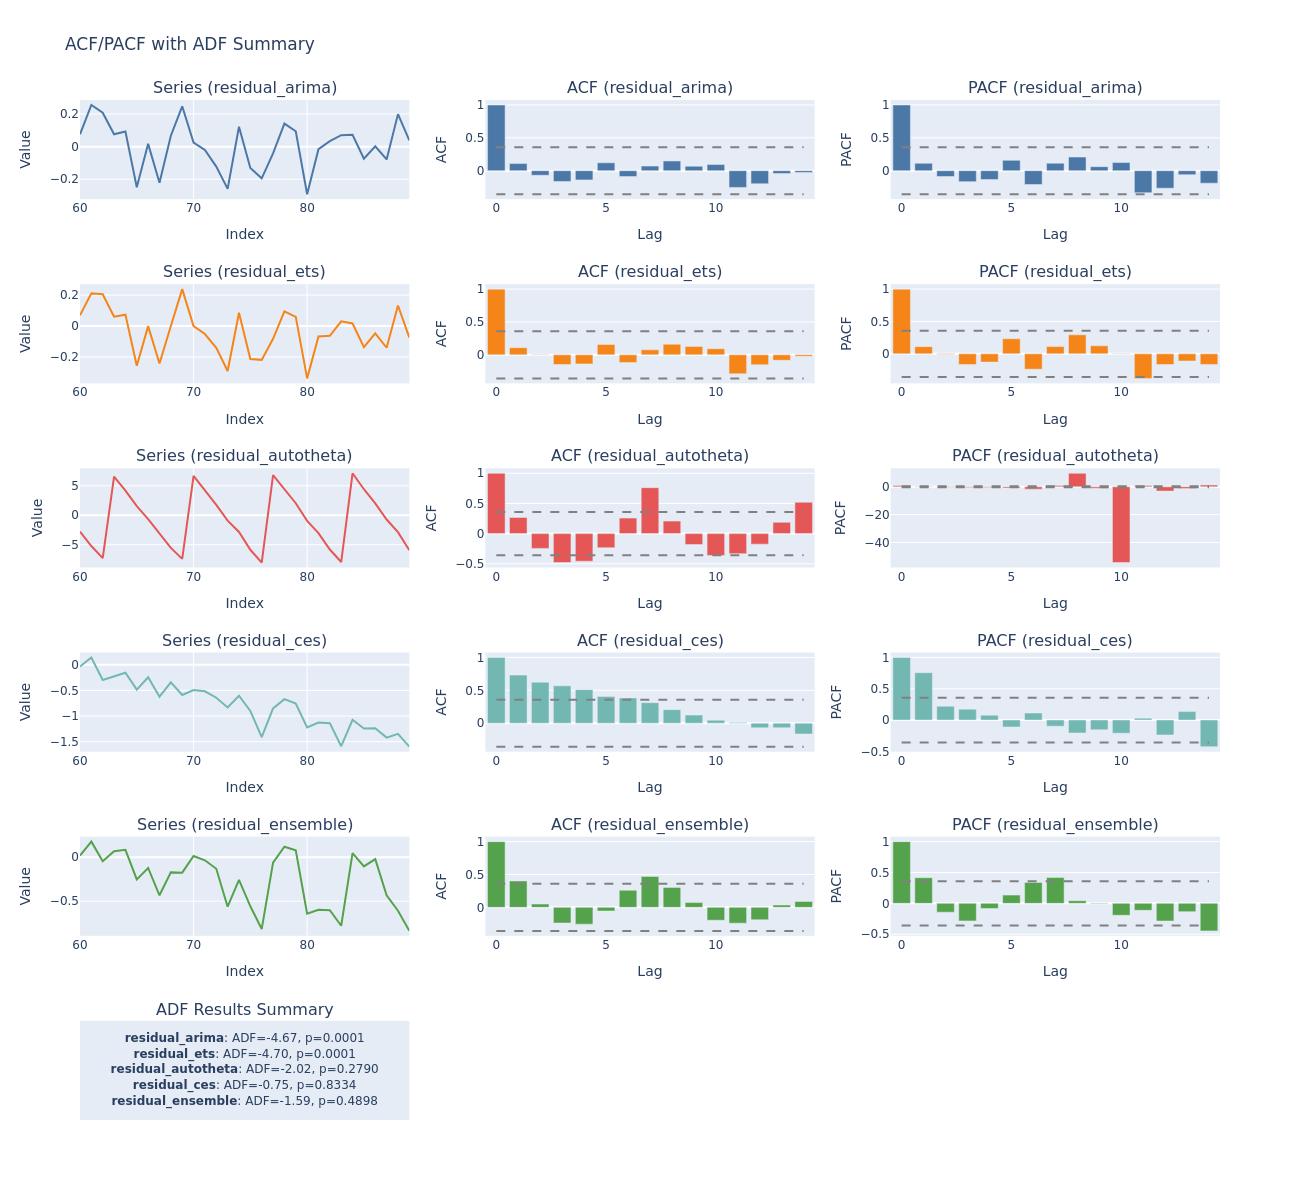

In [31]:
for id in test["unique_id"].unique():
    stationarity_check(test.loc[test["unique_id"] == id, ["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"]], nlags=30, fig_type="png")

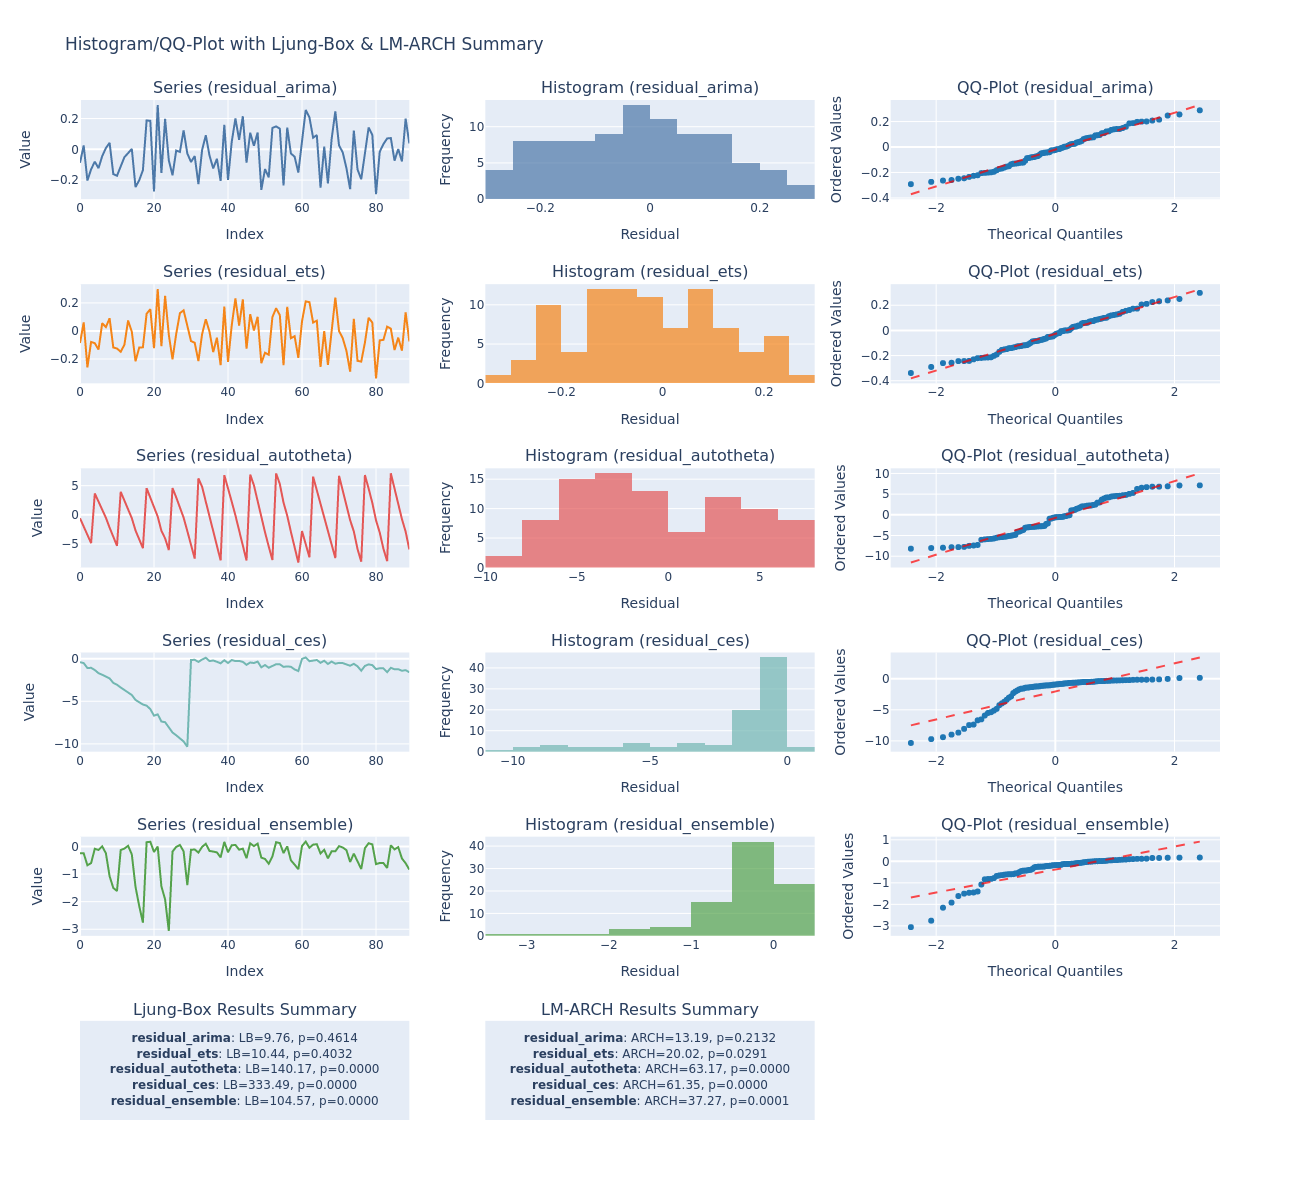

In [32]:
residual_check(test[["residual_arima", "residual_ets", "residual_autotheta", "residual_ces", "residual_ensemble"]], fig_type="png")

# Modelagem Estatística

In [33]:
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean, Offset, Combine
from mlforecast.target_transforms import Differences
from scipy import signal
from sklearn.linear_model import LinearRegression

In [34]:
models = [LinearRegression()]

In [35]:
fcst = MLForecast(
    models=models,
    freq='D',
    lags=[7, 14],
    lag_transforms={
        1: [signal.detrend]
    },
    date_features=['ds'],
)

In [36]:
df

,ds,unique_id,y,lag_1,detrend,detrend_lag_7,weekly_sin,weekly_cos,yearly_sin,yearly_cos,is_holiday,is_month_end
7,2000-01-08,0,3.158659,-5.654389,-3.083234,-0.025326,-0.974928,-0.222521,0.137279,0.990532,False,False
8,2000-01-09,0,4.853702,1.695043,-1.829943,-0.069444,-0.781831,0.623490,0.154309,0.988023,False,False
9,2000-01-10,0,5.997495,1.143794,-1.127902,-0.275262,0.000000,1.000000,0.171293,0.985220,False,False
10,2000-01-11,0,7.771321,1.773826,0.204171,0.133041,0.781831,0.623490,0.188227,0.982126,False,False
11,2000-01-12,0,9.320630,1.549309,1.311728,0.414247,0.974928,-0.222521,0.205104,0.978740,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
1030,2001-01-28,2,226.146458,1.429693,-2.112705,-0.216809,-0.781831,0.623490,0.463550,0.886071,False,False
1031,2001-01-29,2,227.816876,1.670418,-1.014928,-0.093681,0.000000,1.000000,0.478734,0.877960,False,False
1032,2001-01-30,2,229.349496,1.532620,-0.054948,0.211603,0.781831,0.623490,0.493776,0.869589,False,False
1033,2001-01-31,2,231.123892,1.774396,1.146808,0.213440,0.974928,-0.222521,0.508671,0.860961,False,True


In [37]:
from collections import Counter

In [38]:
X = np.asarray(df['y'], dtype=np.float64)
delay = 1
m = 2
N = X.shape[0] - delay * (m - 1)
window_indices = [np.arange(i, i + delay * m, delay) for i in range(N)]
X = np.argsort(X[window_indices], axis=1)

In [39]:
patterns = Counter(map(tuple, X))

In [40]:
probs = {k: v / sum(patterns.values()) for k, v in patterns.items()}

In [41]:
probs = np.array(list(probs.values()))

In [131]:
import numpy as np
from collections import Counter
from typing import Union, List

def permutation_auto_mutual_information(
    X: Union[np.ndarray, List[float]],
    tau: int = 1,
    m: int = 3,
    delay: int = 1,
    normalize: bool = False,
) -> float:
    """
    Calculate the Permutation Auto-Mutual Information (PAMI) of a time series.

    PAMI measures the information dependency between a time series X and itself
    delayed by a lag 'tau', using ordinal patterns.

    Parameters
    ----------
    X : array-like, shape (n_samples,)
        Time series data (e.g., closing prices, measurements).
    tau : int, optional (default=1)
        The main time lag for calculating Auto-Mutual Information:
        compares X(t) with X(t + tau).
    m : int, optional (default=3)
        The embedding dimension (length of ordinal pattern).
    delay : int, optional (default=1)
        The embedding delay (internal spacing of the pattern).

    Returns
    -------
    float
        The Permutation Auto-Mutual Information of the time series for lag 'tau'.

    Notes
    -----
    The function calculates I_P(X(t); X(t + tau)) = sum P(pi_Y, pi_Z) * log2(P(pi_Y, pi_Z) / (P(pi_Y) * P(pi_Z))).
    
    Higher PAMI values indicate stronger temporal dependencies between ordinal patterns,
    while values near zero suggest independence between current and lagged patterns.
    
    This measure is robust to noise and outliers due to its ordinal nature, making it
    useful for detecting non-linear predictive relationships in time series.
    """
    X = np.asarray(X, dtype=np.float64)

    if X.ndim != 1:
        raise ValueError("Input data must be 1-dimensional")
    if m < 2:
        raise ValueError("m must be at least 2")
    if tau < 1 or delay < 1:
        raise ValueError("tau and delay must be at least 1")
    if len(X) < (m - 1) * delay + 1:
        raise ValueError("Time series is too short for the given m and delay")
    if tau + (m - 1) * delay >= len(X):
        raise ValueError("Time series is too short for the given tau, m, and delay")

    N = X.shape[0] - delay * (m - 1) - tau
    window_x = [np.arange(i, i + delay * m, delay) for i in range(N)]
    window_z = [np.arange(i + tau, i + tau + delay * m, delay) for i in range(N)]

    def generate_probabilities(patterns):
        """Helper function to generate probabilities from patterns."""
        patterns = Counter(patterns)
        total_count = sum(patterns.values())
        return {k: v / total_count for k, v in patterns.items()}
    
    patterns_X = np.argsort(X[window_x], axis=1)
    patterns_Z = np.argsort(X[window_z], axis=1)
    
    joint_patterns = list(zip(map(tuple, patterns_X), map(tuple, patterns_Z)))
    prob_joint = generate_probabilities(joint_patterns)

    patterns_X = list(map(tuple, patterns_X))
    prob_X = generate_probabilities(patterns_X)

    patterns_Z = list(map(tuple, patterns_Z))
    prob_Z = generate_probabilities(patterns_Z)

    joint_keys = list(prob_joint.keys())
    prob_joint = np.array(list(prob_joint.values()))

    shannon_X = -np.sum(list(prob_X.values()) * np.log2(list(prob_X.values())))
    shannon_Z = -np.sum(list(prob_Z.values()) * np.log2(list(prob_Z.values())))
    H_min = np.min([shannon_X, shannon_Z])

    prob_X = np.array([prob_X[key[0]] for key in joint_keys]) #Filtering to match joint keys
    prob_Z = np.array([prob_Z[key[1]] for key in joint_keys])   #Filtering to match joint keys
    pami = np.sum(prob_joint * np.log2(prob_joint / (prob_X * prob_Z)))

    return pami if not normalize else pami / H_min if H_min > 0 else 0.0

In [140]:
permutation_auto_mutual_information(X=df['y'], tau=1, m=3, delay=1)

np.float64(0.628480299649866)

In [142]:
import plotly.graph_objects as go

def plot_pami(X, nlags=30, m=3, delay=1, color=None, normalize=False, fig_type=None):
    """
    Plots the Permutation Auto-Mutual Information (PAMI) for lags from 1 to nlags, using bar style and confidence band.
    Highlights the minimum criterion (lowest PAMI value) and annotates the lag.

    Parameters
    ----------
    X : array-like
        Time series data.
    nlags : int
        Maximum lag to compute PAMI.
    m : int
        Embedding dimension.
    delay : int
        Embedding delay.
    color : str or None
        Bar color (optional).
    """
    lags = np.arange(1, nlags + 1)
    pami_values = np.array([permutation_auto_mutual_information(X, tau=lag, m=m, delay=delay, normalize=normalize) for lag in lags])
    minimum_criterion = np.argmin(pami_values)
    min_lag = lags[minimum_criterion]
    min_value = pami_values[minimum_criterion]
    
    N = len(X)
    conf = 1.96 / np.sqrt(N)
    
    pami_bar = go.Bar(
        x=lags,
        y=pami_values,
        marker_color=color,
        name="PAMI",
    )
    band_upper = go.Scatter(
        x=lags,
        y=[conf] * len(lags),
        mode="lines",
        line=dict(color="gray", dash="dash"),
        showlegend=False,
        name="Confidence Band",
    )
    band_lower = go.Scatter(
        x=lags,
        y=[-conf] * len(lags),
        mode="lines",
        line=dict(color="gray", dash="dash"),
        showlegend=False,
        name="Confidence Band",
    )
    min_marker = go.Scatter(
        x=[min_lag],
        y=[min_value],
        mode="markers",
        marker=dict(color="red", size=4, symbol="circle"),
        name="Minimum Criterion",
        showlegend=True,
    )
    min_text = go.Scatter(
        x=[min_lag],
        y=[min_value],
        mode="text",
        text=[f"{min_lag}"],
        textposition="top center",
        showlegend=False,
    )
    fig = go.Figure([pami_bar, band_upper, band_lower, min_marker, min_text])
    fig.update_layout(
        title=f"Permutation Auto-Mutual Information (PAMI) by Lag",
        xaxis_title="Lag",
        yaxis_title="PAMI",
    )
    return fig.show(fig_type)

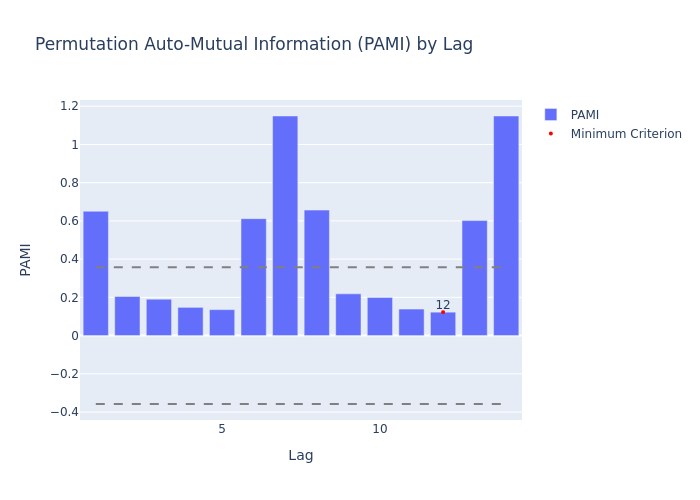

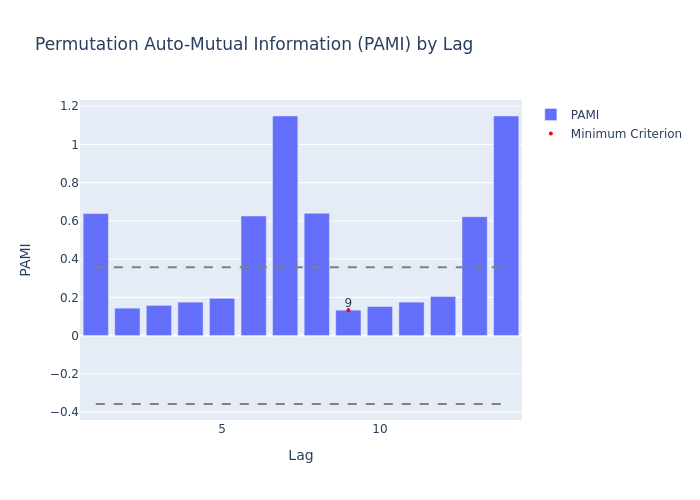

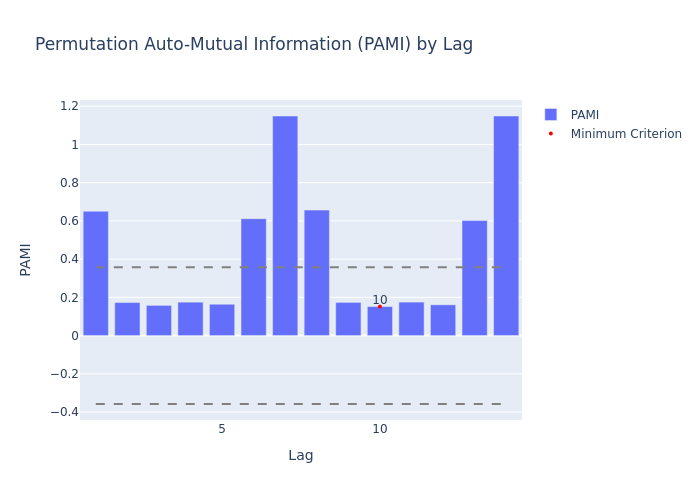

In [147]:
for id in test["unique_id"].unique():
    plot_pami(test.loc[test["unique_id"] == id, "y"], nlags=14, m=3, delay=1, normalize=False, fig_type="png")

In [51]:
len(test.loc[test["unique_id"] == id, "detrend_lag_7"])

30

In [49]:
test.loc[test["unique_id"] == id, "detrend_lag_7"]

0     0.021804
1     0.110548
2    -0.446422
3     0.009070
4     0.086304
5    -0.100863
6    -0.191412
7     0.101306
8     0.017331
9     0.129404
10   -0.059264
11   -0.073287
12    0.022012
13    0.006964
14   -0.045539
15   -0.318814
16   -0.012791
17   -0.003667
18    0.258964
19    0.241711
20   -0.210050
21    0.291910
22    0.095902
23    0.356307
24    0.077038
25   -0.336669
26   -0.188642
27    0.238090
28   -0.163560
29    0.127034
Name: detrend_lag_7, dtype: float64

In [ ]:
df["detrend"] = df.groupby("unique_id")["y"].transform(signal.detrend)
df["detrend_lag_7"] = df.groupby("unique_id")["detrend"].transform(generate_lag, lag=7)

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva